### Introduction 
This document outlines the methodology and steps taken to implement an anomaly detection system using control charts. The system is designed to monitor the vibration data from various bearings (B1, B2, B3, B4) along different axes (x, y). By leveraging statistical process control techniques, specifically Range (R) and X-bar control charts, we aim to detect abnormal behavior in the vibration data which could indicate potential issues or failures in the machinery.

Our approach includes calculating control limits based on historical data, identifying outliers, and using rolling windows to detect sustained anomalies.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [3]:
# Replace 'file_path.csv' with the path to your CSV file
file_path = "/Users/luciefourcault/PycharmProjects/pythonProject/Corporate_Project/merged_dataset.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()
df.tail()

B1x    B1y    B2x    B2y    B3x    B3y    B4x    B4y  \
44154875 -0.168 -0.068 -0.449  0.190  0.117  1.196 -0.037 -0.122   
44154876 -0.112  0.088 -0.493  0.266 -0.266  0.342 -0.339 -0.164   
44154877 -0.081 -0.020 -0.325 -0.049 -0.112 -0.481 -0.300 -0.007   
44154878 -0.115 -0.146 -0.190 -0.427  0.813  0.049 -0.205  0.105   
44154879 -0.098 -0.166  0.012 -0.552 -0.071  0.588 -0.159  0.232   

                  time  measurement_id  
44154875  2.979213e+06            2156  
44154876  2.979213e+06            2156  
44154877  2.979213e+06            2156  
44154878  2.979213e+06            2156  
44154879  2.979213e+06            2156

In [4]:
df

B1x    B1y    B2x    B2y    B3x    B3y    B4x    B4y  \
0        -0.022 -0.039 -0.183 -0.054 -0.105 -0.134 -0.129 -0.142   
1        -0.105 -0.017 -0.164 -0.183 -0.049  0.029 -0.115 -0.122   
2        -0.183 -0.098 -0.195 -0.125 -0.005 -0.007 -0.171 -0.071   
3        -0.178 -0.161 -0.159 -0.178 -0.100 -0.115 -0.112 -0.078   
4        -0.208 -0.129 -0.261 -0.098 -0.151 -0.205 -0.063 -0.066   
...         ...    ...    ...    ...    ...    ...    ...    ...   
44154875 -0.168 -0.068 -0.449  0.190  0.117  1.196 -0.037 -0.122   
44154876 -0.112  0.088 -0.493  0.266 -0.266  0.342 -0.339 -0.164   
44154877 -0.081 -0.020 -0.325 -0.049 -0.112 -0.481 -0.300 -0.007   
44154878 -0.115 -0.146 -0.190 -0.427  0.813  0.049 -0.205  0.105   
44154879 -0.098 -0.166  0.012 -0.552 -0.071  0.588 -0.159  0.232   

                  time  measurement_id  
0         0.000000e+00               1  
1         5.000000e-05               1  
2         1.000000e-04               1  
3         1.500000e-04               1  
4         2.000000e-04               1  
...                ...             ...  
44154875  2.979213e+06            2156  
44154876  2.979213e+06            2156  
44154877  2.979213e+06            2156  
44154878  2.979213e+06            2156  
44154879  2.979213e+06            2156  

[44154880 rows x 10 columns]

## Range Control Chart (R Chart)

The range (difference between maximum and minimum values) of vibration data for each measurement is calculated.
Control limits (UCL - Upper Control Limit, LCL - Lower Control Limit) are computed using the initial set of points to establish a baseline.
A range control chart is plotted for each bearing axis, highlighting outliers that exceed the UCL.


In [5]:
# Calculate the range (max - min) for each 'measurement_id' in 'B1x'
data = df.groupby('measurement_id')['B1x'].apply(lambda x: x.max() - x.min())
data

measurement_id
1       1.108
2       1.042
3       0.940
4       1.055
5       1.011
        ...  
2152    1.145
2153    1.316
2154    1.159
2155    1.298
2156    1.438
Name: B1x, Length: 2156, dtype: float64

### Using B1x and the first 1000 point to calculate the UCL (Upper Control Limit)

We use only B1X and the first 1000 points to calculate the UCL. We only use UCL because they are ranges and we don't take into account if a point is lower than LCL because that would mean lower vibration

In [6]:
b1x_data = df[['B1x', 'measurement_id']]
b1x_data

B1x  measurement_id
0        -0.022               1
1        -0.105               1
2        -0.183               1
3        -0.178               1
4        -0.208               1
...         ...             ...
44154875 -0.168            2156
44154876 -0.112            2156
44154877 -0.081            2156
44154878 -0.115            2156
44154879 -0.098            2156

[44154880 rows x 2 columns]

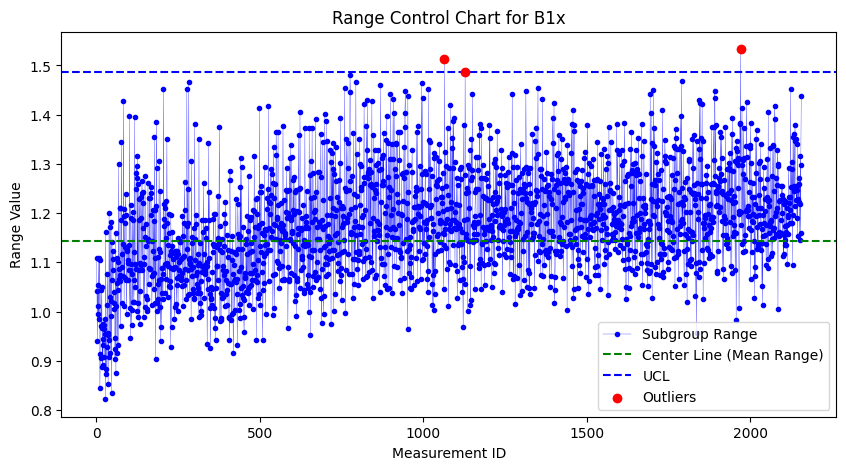

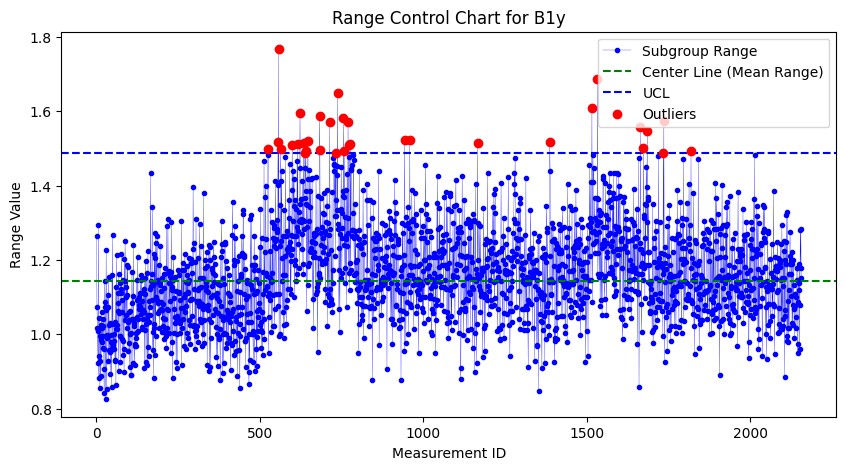

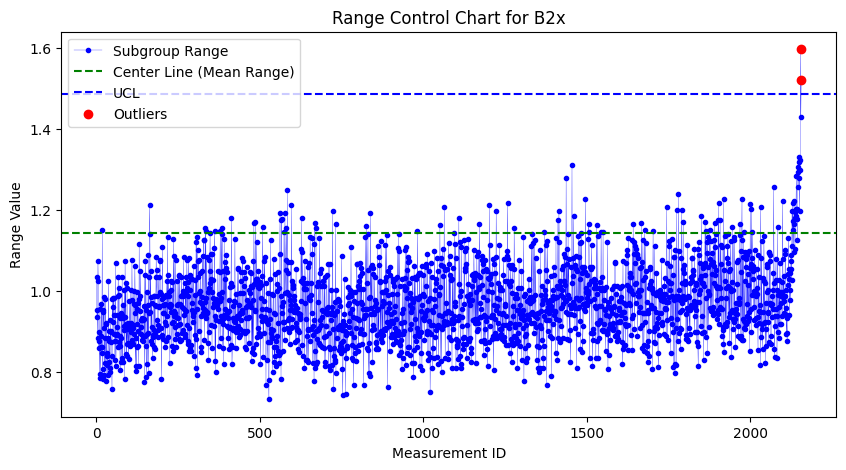

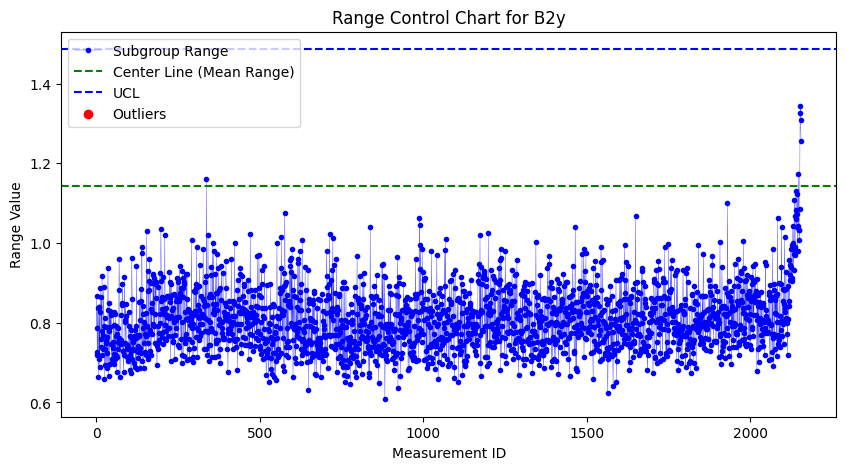

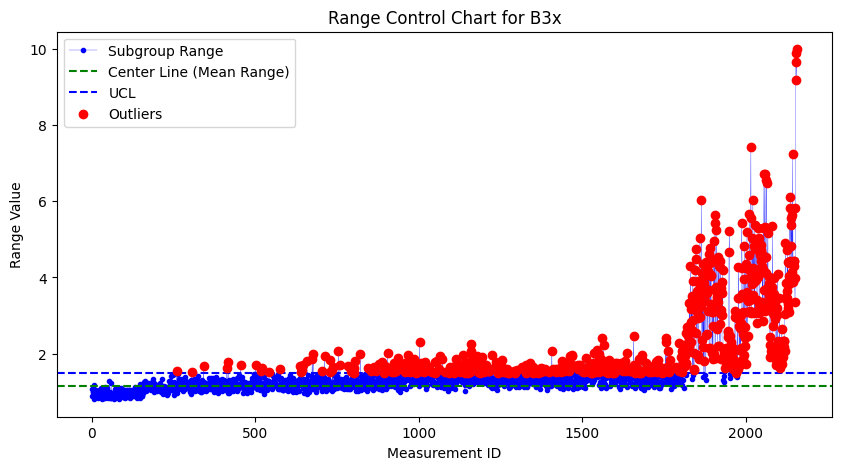

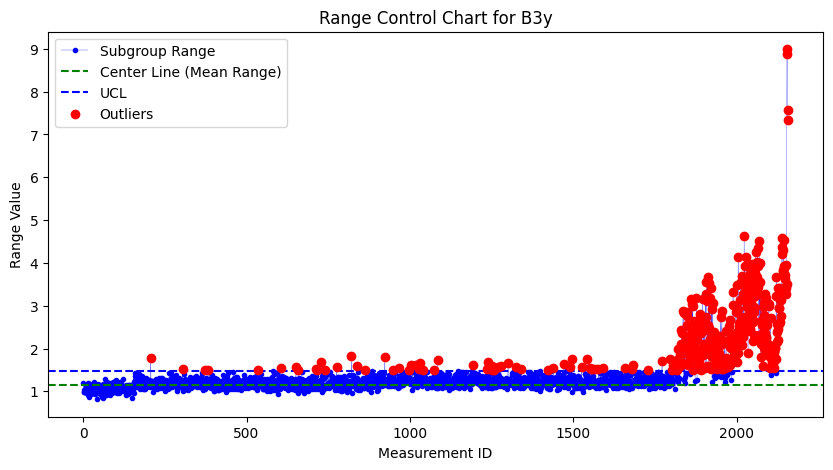

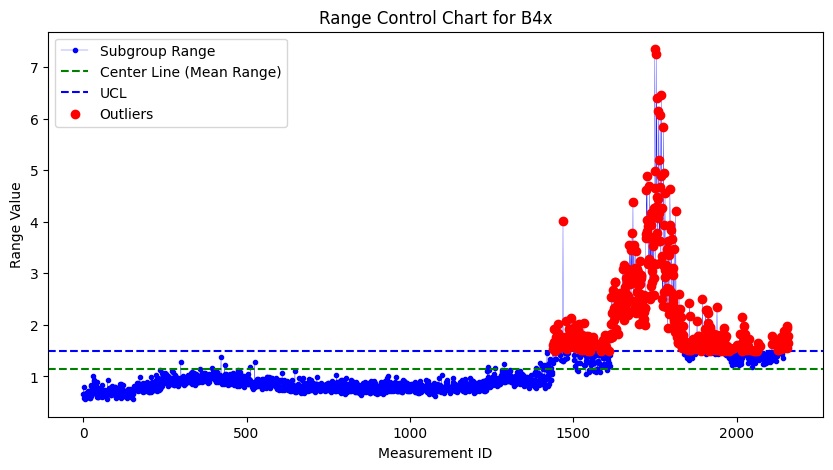

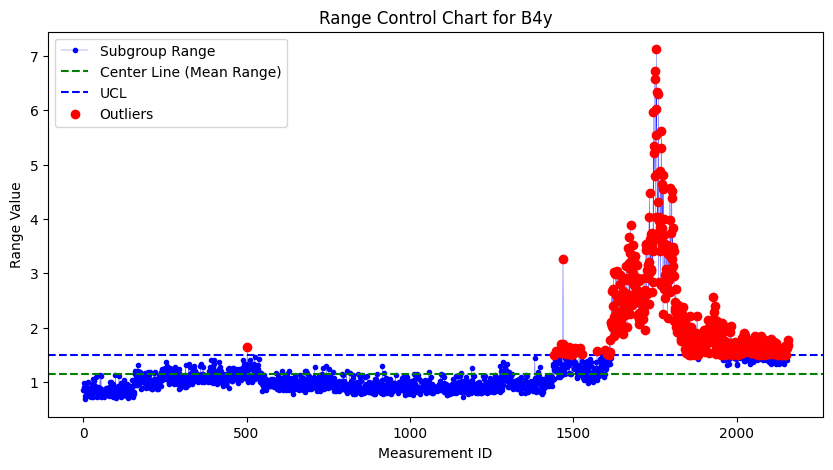

In [7]:
def plot_range_chart_with_initial_points(data, column_name,initial_points = 1000):
    # Calculate the range for each subgroup
    subgroup_ranges_b1x = b1x_data.groupby('measurement_id')['B1x'].apply(lambda x: x.max() - x.min())
    subgroup_ranges = data.groupby('measurement_id')[column_name].apply(lambda x: x.max() - x.min())
    
    # Calculate the mean and standard deviation of the ranges based on the initial points
    initial_subgroup_ranges = subgroup_ranges_b1x[:initial_points]
    range_mean = initial_subgroup_ranges.mean()
    range_std = initial_subgroup_ranges.std()  # Standard deviation of the ranges
    
    # Define control limits
    ucl = range_mean + 3 * range_std
    lcl = range_mean - 3 * range_std
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_ranges.index, subgroup_ranges, marker='o', linestyle='-', color='b', markersize=3, lw=0.2, label='Subgroup Range')
    plt.axhline(y=range_mean, color='green', linestyle='--', label='Center Line (Mean Range)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')
    
    # Highlighting outliers
    outliers = subgroup_ranges[(subgroup_ranges > ucl)]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)
    
    plt.title(f'Range Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Range Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a range control chart for each column based on the first 100 points
for column in columns:
    plot_range_chart_with_initial_points(df, column)


## Outliers detection

For each bearing axis, outliers are identified by comparing the range values against the control limits.A dictionary is created to store the outliers for each bearing axis as you can see in the following code snippet.


In [8]:
#Finding Outliers
def find_outliers(data, column_name):
    # Calculate the range for each subgroup
    subgroup_ranges = data.groupby('measurement_id')[column_name].apply(lambda x: x.max() - x.min())
    
    # Calculate the mean and standard deviation of the ranges
    range_mean = subgroup_ranges.mean()
    range_std = subgroup_ranges.std()  # Standard deviation of the ranges
    
    # Define control limits
    ucl = range_mean + 3 * range_std
    lcl = range_mean - 3 * range_std

    # Identify the outliers
    outliers = subgroup_ranges[(subgroup_ranges > ucl) | (subgroup_ranges < lcl)].index.tolist()
    return outliers

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Dictionary to store outliers for each column
outliers_dict = {}

# Find outliers for each column
for column in columns:
    outliers_dict[column] = find_outliers(df, column)

# Print or return the dictionary of outliers
print(outliers_dict)


{'B1x': [11, 28, 36, 47, 1065, 1971], 'B1y': [558, 623, 683, 714, 738, 756, 770, 1516, 1533, 1736], 'B2x': [1437, 1455, 2141, 2145, 2146, 2148, 2149, 2150, 2152, 2153, 2154, 2155, 2156], 'B2y': [337, 577, 988, 1650, 1931, 2084, 2135, 2136, 2140, 2141, 2142, 2144, 2145, 2148, 2152, 2153, 2154, 2155, 2156], 'B3x': [1848, 1860, 1864, 1887, 1890, 1902, 1906, 1907, 1910, 1915, 1949, 1950, 1988, 1996, 2004, 2009, 2011, 2015, 2016, 2020, 2022, 2025, 2027, 2029, 2030, 2033, 2038, 2040, 2045, 2046, 2047, 2050, 2054, 2056, 2059, 2060, 2062, 2063, 2064, 2065, 2068, 2082, 2121, 2127, 2135, 2137, 2138, 2139, 2140, 2142, 2144, 2152, 2153, 2154, 2155, 2156], 'B3y': [1906, 1913, 1915, 1921, 1988, 2000, 2004, 2011, 2015, 2016, 2020, 2022, 2024, 2027, 2029, 2033, 2035, 2036, 2038, 2045, 2046, 2047, 2054, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2068, 2070, 2072, 2121, 2127, 2133, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2152, 2153, 2154

## Xbar Control Chart: 

The mean (average) of vibration data for each measurement is calculated.
Control limits are defined based on the mean and standard deviation of the initial set of points.
An X-bar control chart is plotted, highlighting any outliers that fall outside the control limits.

In [9]:
# Calculate the standard deviation of the means of 'B1x' grouped by 'measurement_id'
data_means = df.groupby('measurement_id')['B1x'].mean().std()
data_means

0.005848738162583942

### Observations: 
1. We tried to use the first 400 points to integrate in the control chart but it does not work because the initial points are far above the standard deviation limits across all bearings. 

2. Control chart needs to skip the first points because mean is disrupted by the noise of these points, that's why we choose not to include the 400 firsts points in the control chart.

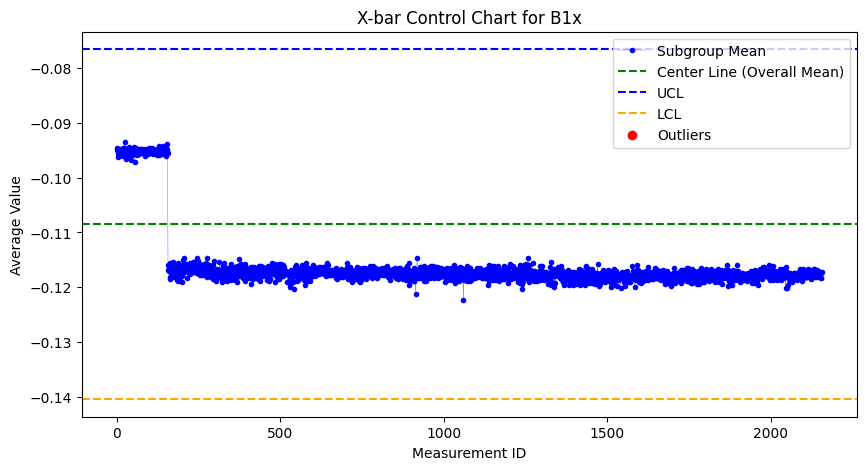

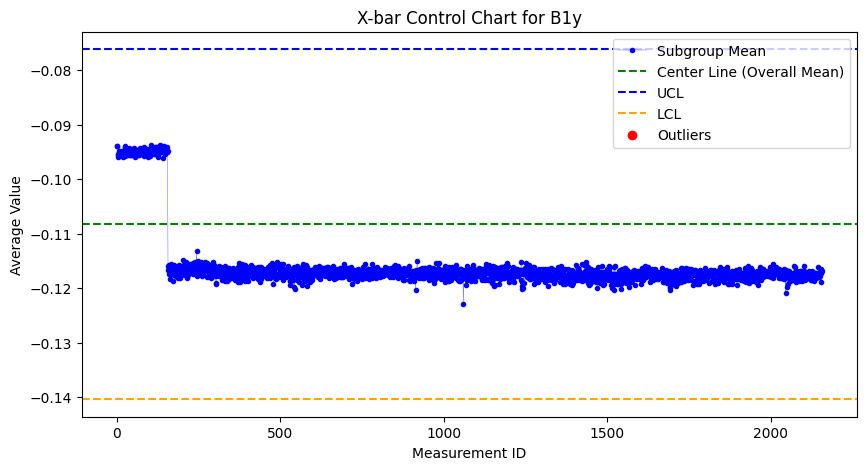

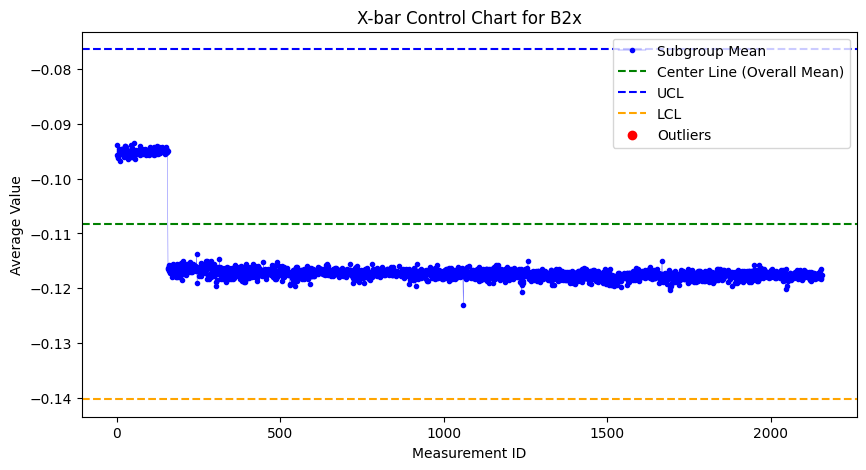

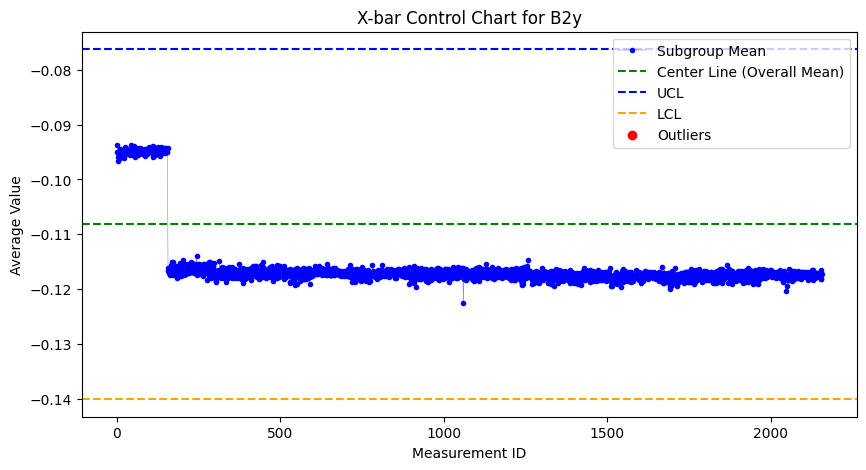

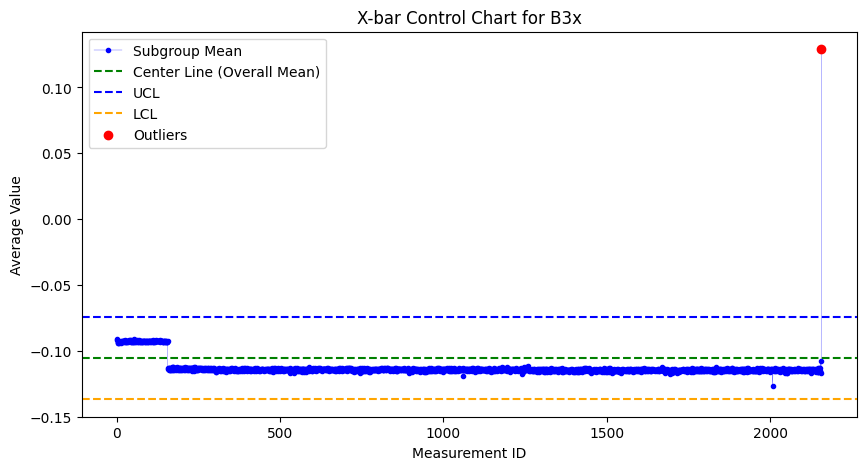

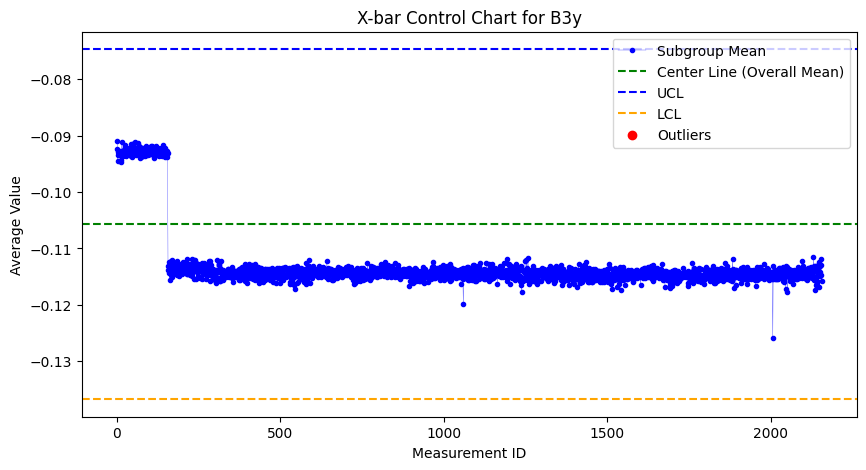

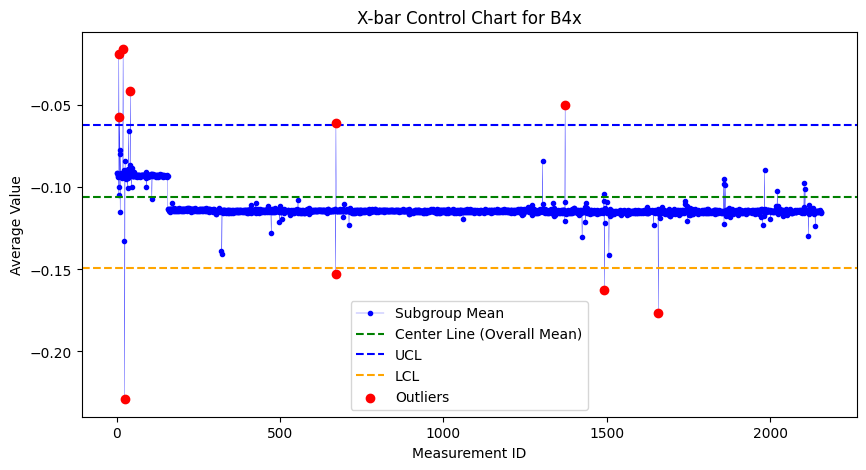

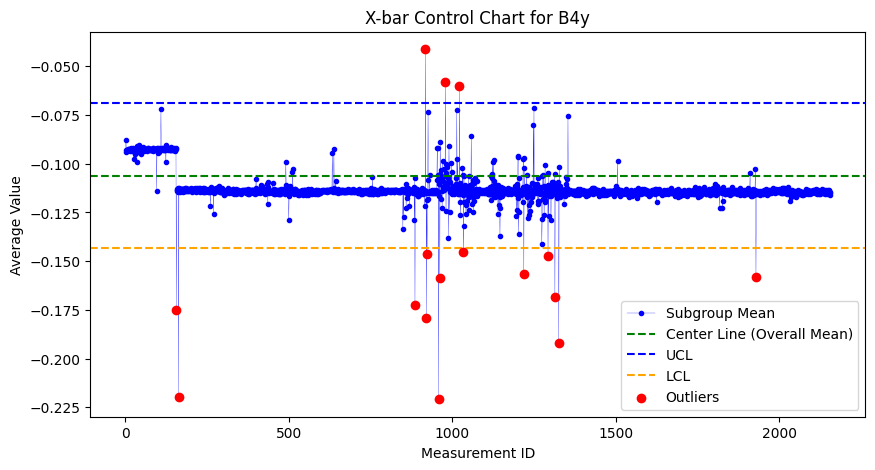

In [10]:
#Plot Xbar Chart
def plot_x_bar_chart_with_specific_points(data, column_name, end=400):
    # Group data by measurement_id and calculate the mean of each group
    subgroup_means = data.groupby('measurement_id')[column_name].mean()

    # Select the range of points from 0 to end
    specific_subgroup_means = subgroup_means[:end]
    overall_mean = specific_subgroup_means.mean()
    standard_deviation = specific_subgroup_means.std()  # Standard deviation of the subgroup means
    
    # Define control limits
    ucl = overall_mean + 3 * standard_deviation
    lcl = overall_mean - 3 * standard_deviation
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_means.index, subgroup_means, marker='o', linestyle='-', color='b', label='Subgroup Mean', lw=0.2, markersize=3)
    plt.axhline(y=overall_mean, color='green', linestyle='--', label='Center Line (Overall Mean)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')
    plt.axhline(y=lcl, color='orange', linestyle='--', label='LCL')
    
    # Highlighting outliers
    outliers = subgroup_means[(subgroup_means > ucl) | (subgroup_means < lcl)]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)
    
    plt.title(f'X-bar Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Average Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a control chart for each column based on the points from 0 to 400
for column in columns:
    plot_x_bar_chart_with_specific_points(df, column, end=400)



### Solution: using only data points between 400 and 500
We tried to solve the problem of the initial data by calculating UCL and LCL with points 400 to 500

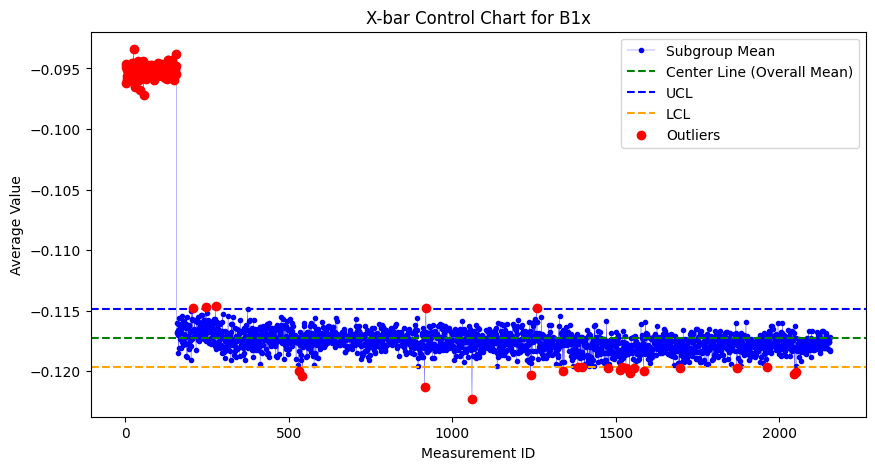

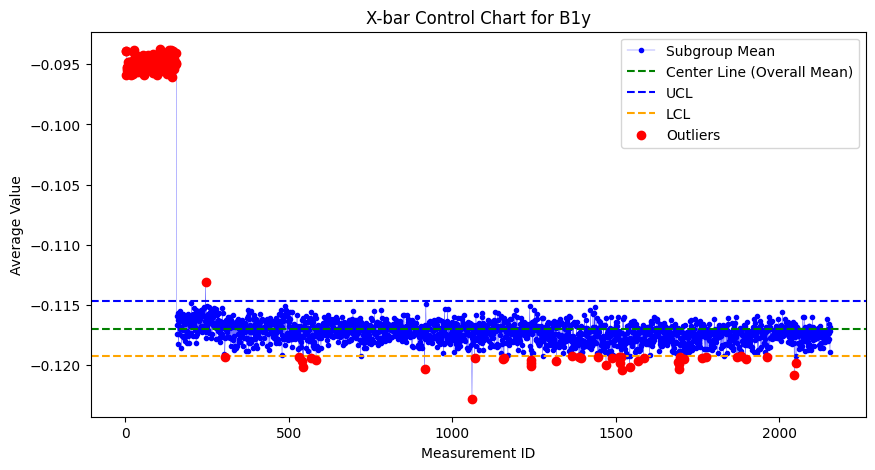

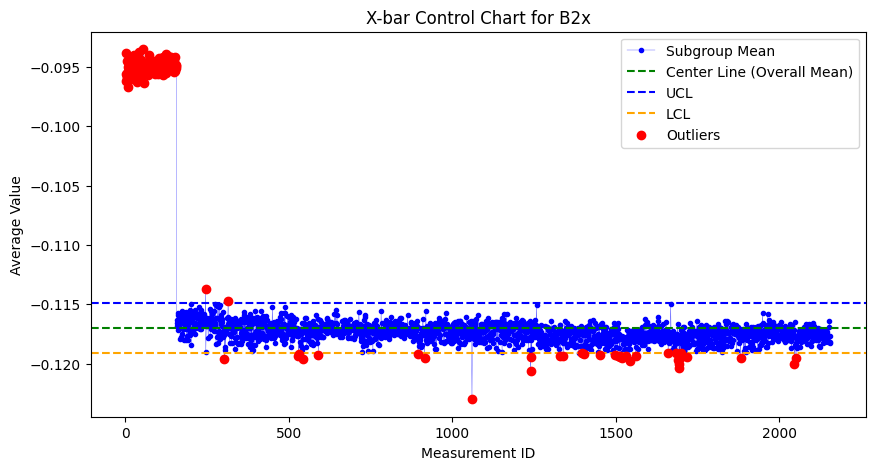

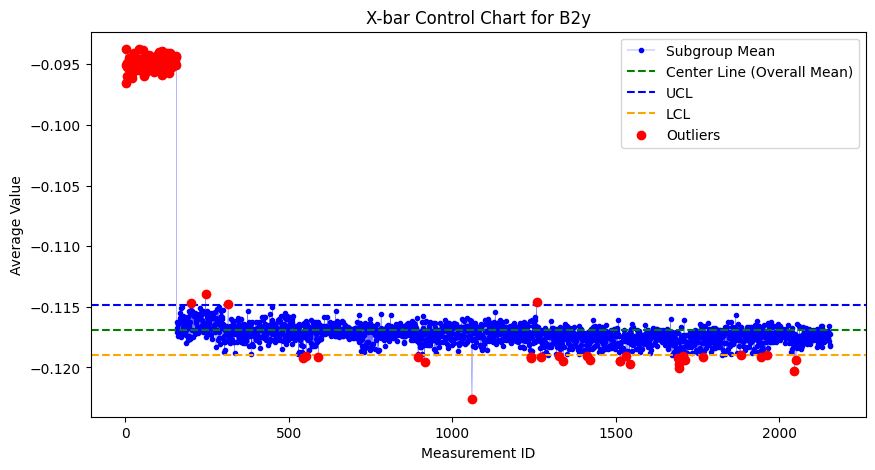

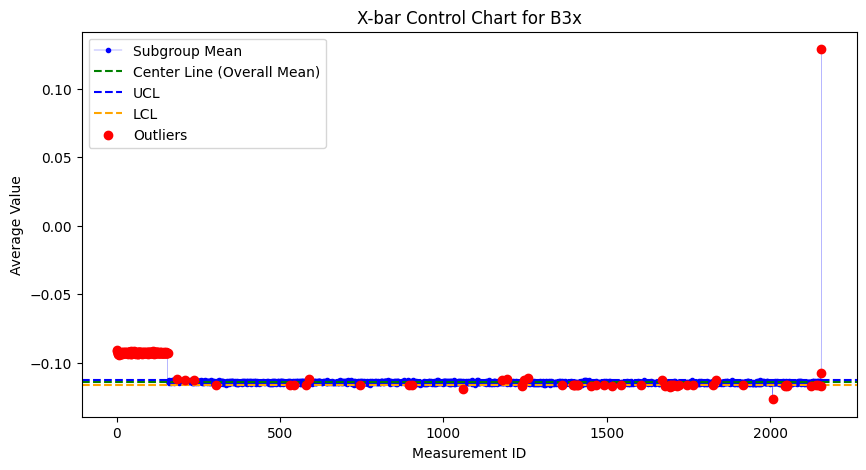

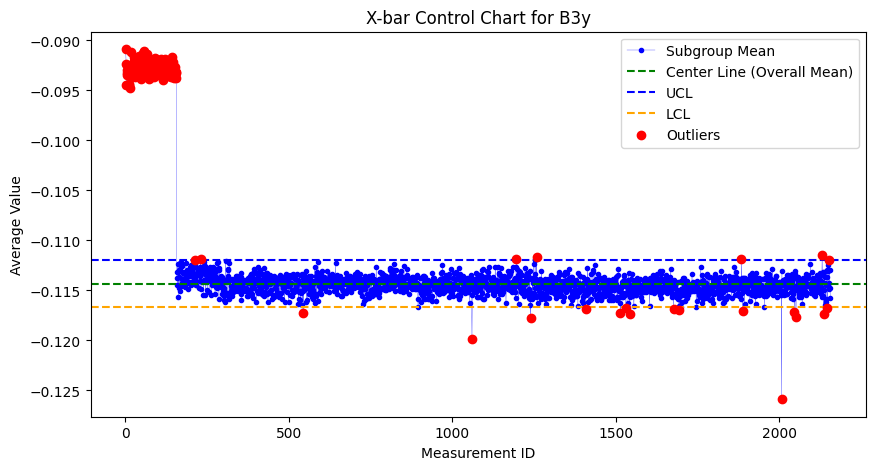

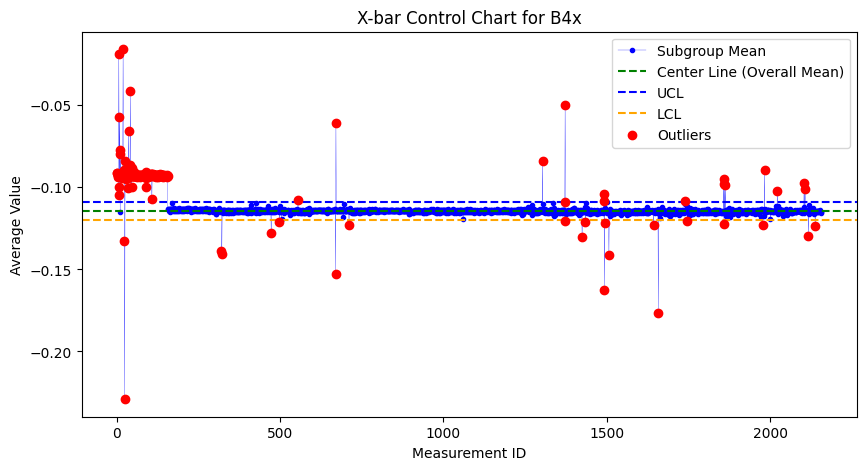

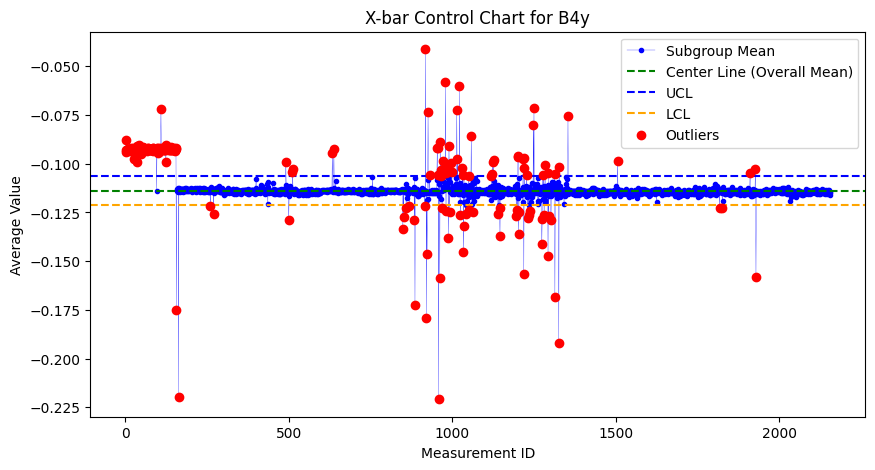

In [11]:
def plot_x_bar_chart_with_specific_points(data, column_name, start=400, end=500):
    # Group data by measurement_id and calculate the mean of each group
    subgroup_means = data.groupby('measurement_id')[column_name].mean()

    # Select the range of points between start and end
    specific_subgroup_means = subgroup_means[start:end]
    overall_mean = specific_subgroup_means.mean()
    standard_deviation = specific_subgroup_means.std()  # Standard deviation of the subgroup means
    
    # Define control limits
    ucl = overall_mean + 3 * standard_deviation
    lcl = overall_mean - 3 * standard_deviation
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_means.index, subgroup_means, marker='o', linestyle='-', color='b', label='Subgroup Mean', lw=0.2, markersize=3)
    plt.axhline(y=overall_mean, color='green', linestyle='--', label='Center Line (Overall Mean)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')
    plt.axhline(y=lcl, color='orange', linestyle='--', label='LCL')
    
    # Highlighting outliers
    outliers = subgroup_means[(subgroup_means > ucl) | (subgroup_means < lcl)]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)
    
    plt.title(f'X-bar Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Average Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a control chart for each column based on the points between 100 and 150
for column in columns:
    plot_x_bar_chart_with_specific_points(df, column)


In [12]:
 standard_error = df['B4y'].sem()
 standard_error

1.4889215246956128e-05

In [13]:
standard_deviation = df['B4y'].std()
standard_deviation

0.09893755252731187

In [14]:
overall_mean = df['B4y'].mean()
overall_mean

-0.11272051059814917

## Algorithm 1: Creating Detection process with control chart

### Detection 1: control chart. 
If X outliers are present in a rolling window of N points outliers are detected. 

### Tip:
To change those threshold, input different numbers in the plot_range_chart function

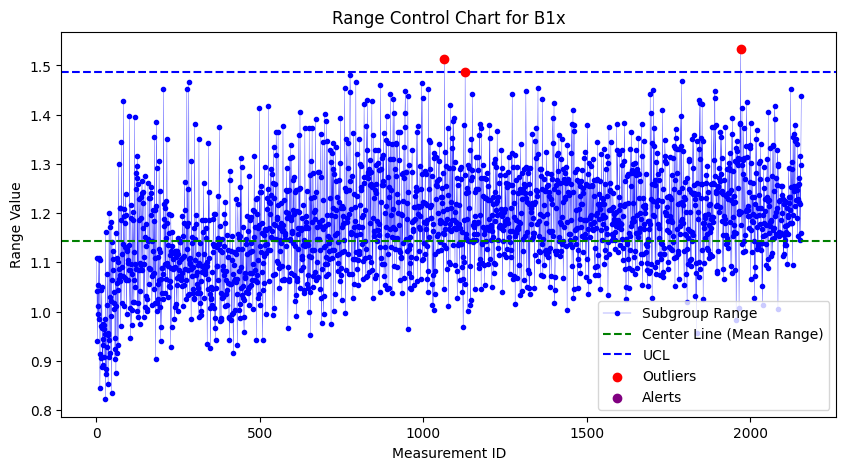

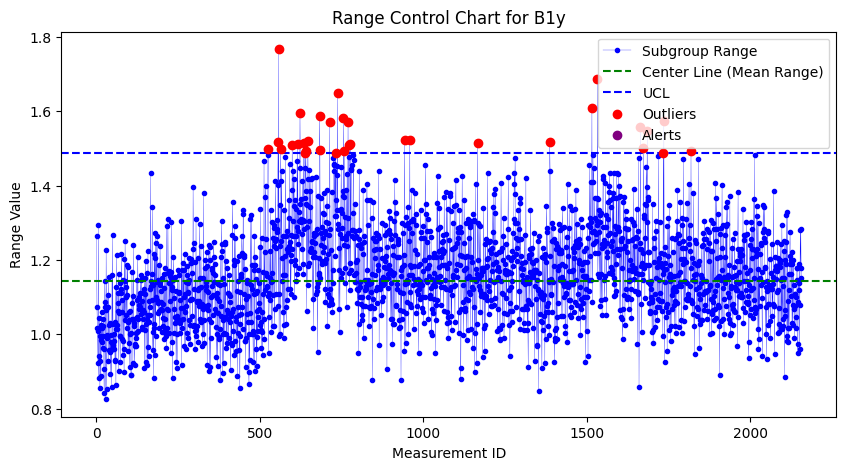

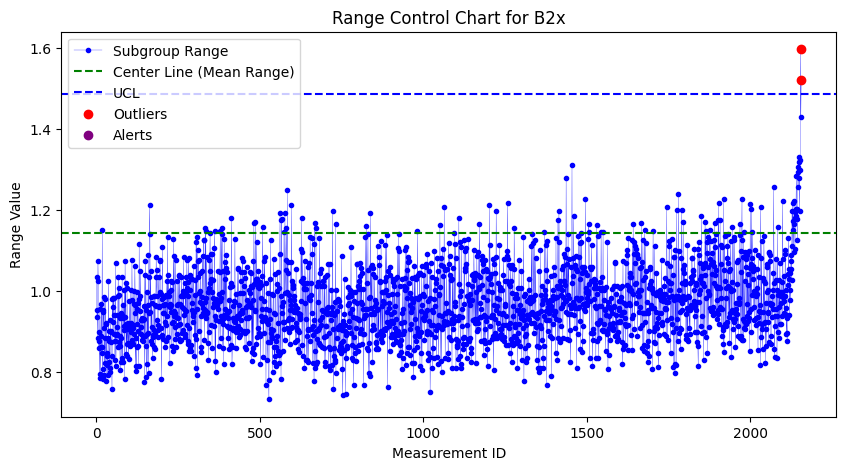

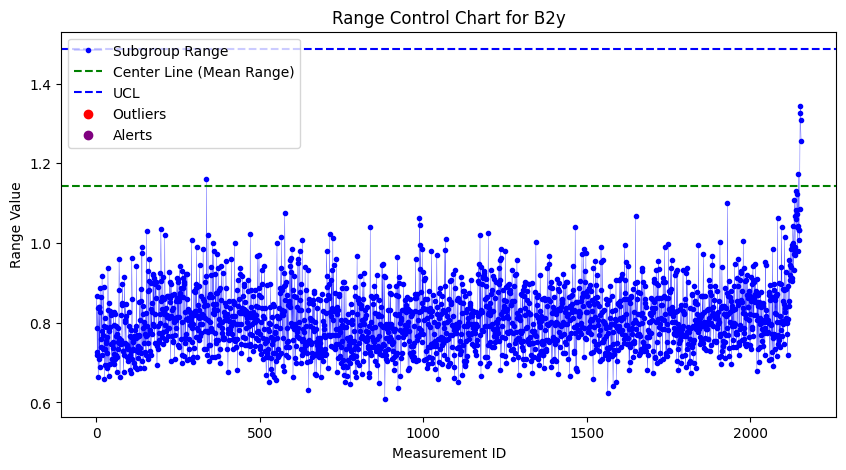

Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1166, value: 1.697
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1169, value: 1.597
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1551, value: 1.516
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1808, value: 1.8170000000000002
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1810, value: 2.229
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1812, value: 1.6869999999999998
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1813, value: 2.048
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1814, value: 1.68

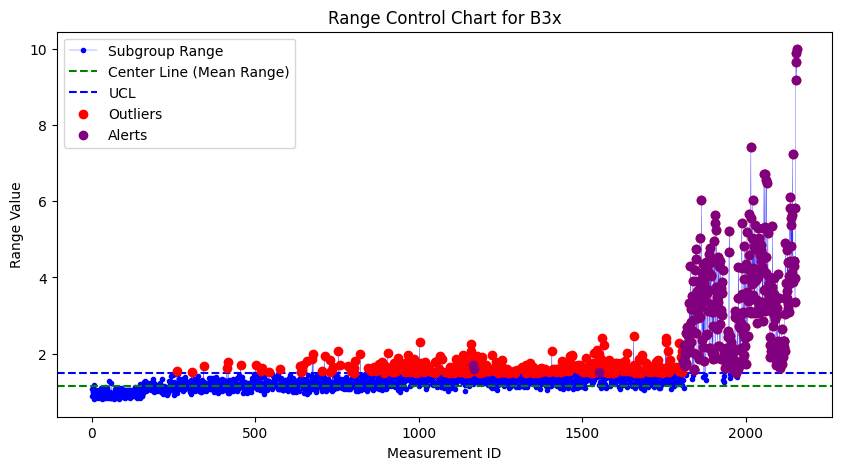

Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1826, value: 1.643
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1827, value: 1.853
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1828, value: 2.112
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1829, value: 1.892
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1830, value: 2.429
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1831, value: 1.929
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1832, value: 1.663
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1833, value: 2.3680000000000003
Alert: anom

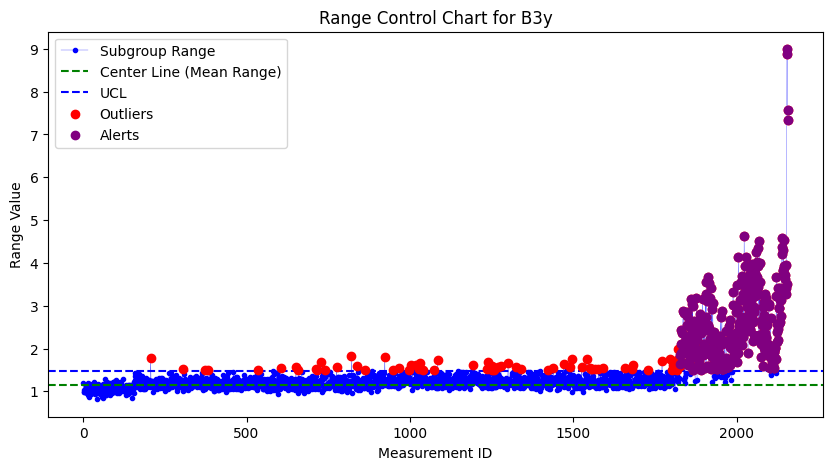

Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1450, value: 1.709
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1451, value: 1.717
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1452, value: 1.853
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1453, value: 1.721
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1454, value: 2.0220000000000002
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1455, value: 1.655
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1456, value: 1.58
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1457, value: 1.6190000000000002

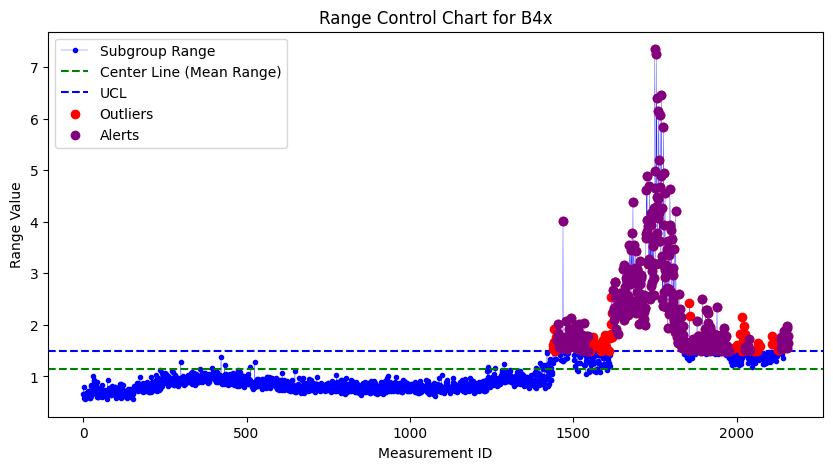

Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1621, value: 1.9940000000000002
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1622, value: 2.388
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1623, value: 3.017
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1624, value: 1.8359999999999999
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1625, value: 2.19
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1626, value: 2.237
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1627, value: 2.2119999999999997
Alert: anomalies detected within a rolling window of 20 and standard deviation of 10 at measurement ID 1628,

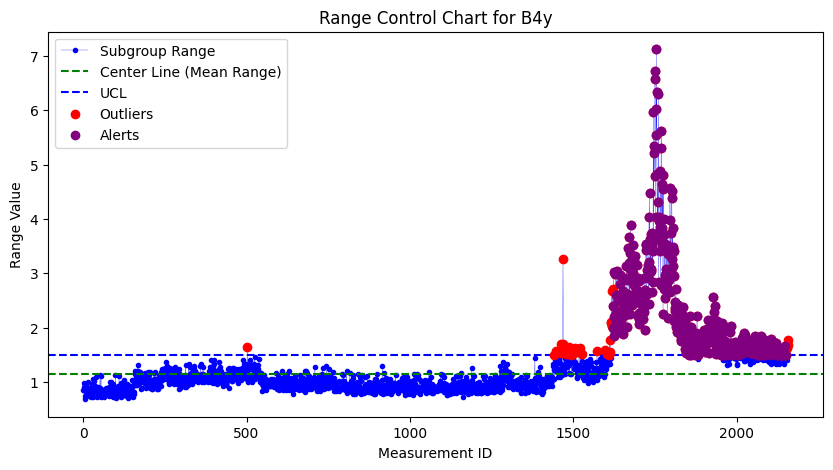

In [18]:
def plot_range_chart(data, column_name, window_size=20, outlier_threshold=10, initial_points = 1000):
    subgroup_ranges = data.groupby('measurement_id')[column_name].apply(lambda x: x.max() - x.min())
    subgroup_ranges_b1x = b1x_data.groupby('measurement_id')['B1x'].apply(lambda x: x.max() - x.min())

    # Calculate the mean and standard deviation of the ranges
    initial_subgroup_ranges = subgroup_ranges_b1x[:initial_points]
    range_mean = initial_subgroup_ranges.mean()
    range_std = initial_subgroup_ranges.std()  # Standard deviation of the ranges

    ucl = range_mean + 3 * range_std

    outliers = (subgroup_ranges > ucl)

    # Create a rolling window to detect anomalies
    rolling_outliers = outliers.rolling(window=window_size).sum()

    # Generate alerts
    alerts = (rolling_outliers > outlier_threshold) & (outliers)

    alert_indices = alerts[alerts].index
    for idx in alert_indices:
        print(f"Alert: anomalies detected within a rolling window of {window_size} and standard deviation of {outlier_threshold} at measurement ID {idx}, value: {subgroup_ranges[idx]}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_ranges.index, subgroup_ranges, marker='o', linestyle='-', color='b', markersize=3, lw=0.2,
             label='Subgroup Range')
    plt.axhline(y=range_mean, color='green', linestyle='--', label='Center Line (Mean Range)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')

    # Highlighting outliers
    plt.scatter(subgroup_ranges.index[outliers], subgroup_ranges[outliers], color='red', label='Outliers', zorder=5)

    # Highlighting alert points
    plt.scatter(alert_indices, subgroup_ranges[alert_indices], color='purple', label='Alerts', zorder=5)

    plt.title(f'Range Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Range Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a range control chart for each column
for column in columns:
    plot_range_chart(df, column)

## Algorithm 2: Identifying trends and making detection process

### Detection 2: 
If the mean in the rolling window of N points is X Standard deviations away from the mean of interval of N points preceding the rolling window, an anomaly is detected

### Tip:
To change the threshold input different number in the function for sd and window_size

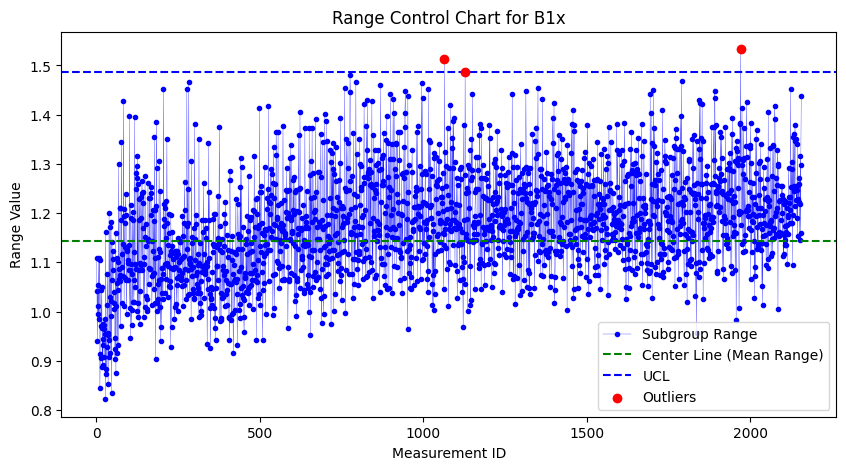

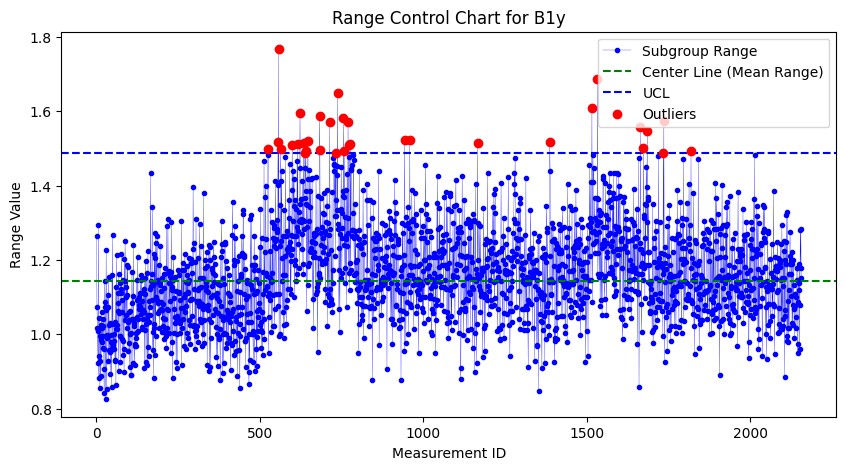

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2136, value: 1.179
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2137, value: 1.103
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2138, value: 1.194
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2139, value: 1.186
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2140, value: 1.203
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2141, value: 1.2839999999999998
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2142, value: 1.201
Alert f

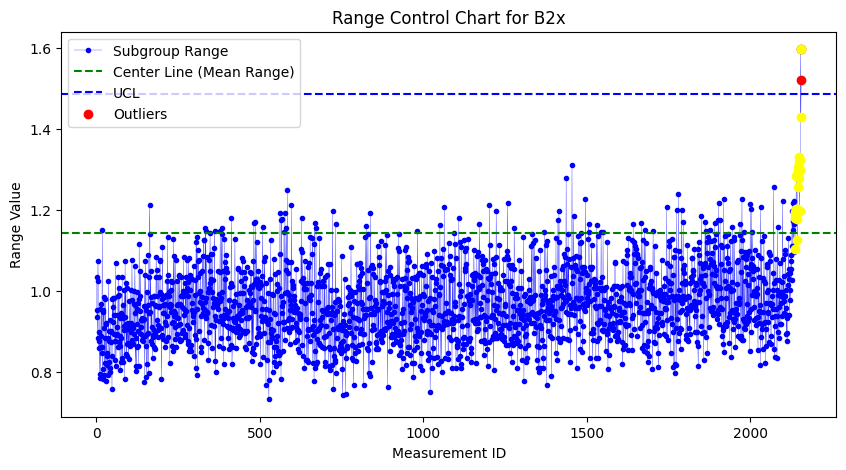

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2136, value: 1.069
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2137, value: 0.971
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2138, value: 0.989
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2139, value: 0.977
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2140, value: 1.082
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2141, value: 1.1300000000000001
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 2142, value: 1.06
Alert fo

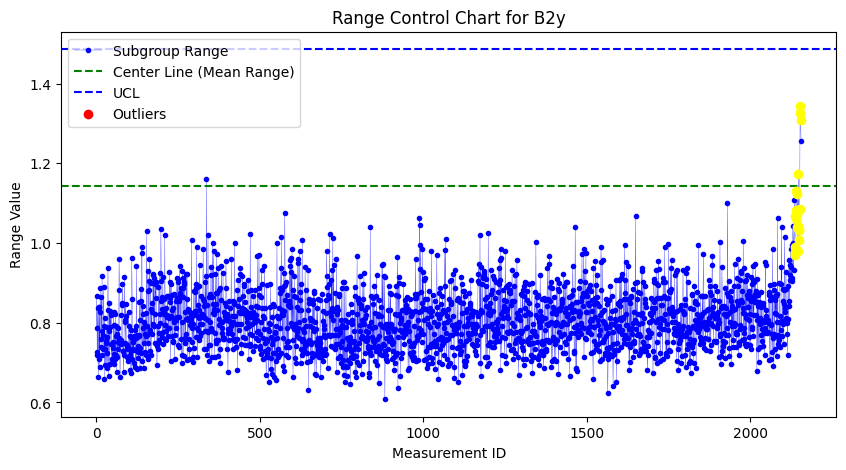

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1818, value: 2.551
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1819, value: 1.4260000000000002
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1820, value: 2.246
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1821, value: 2.702
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1822, value: 2.085
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1823, value: 2.034
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1824, value: 2.109
Alert f

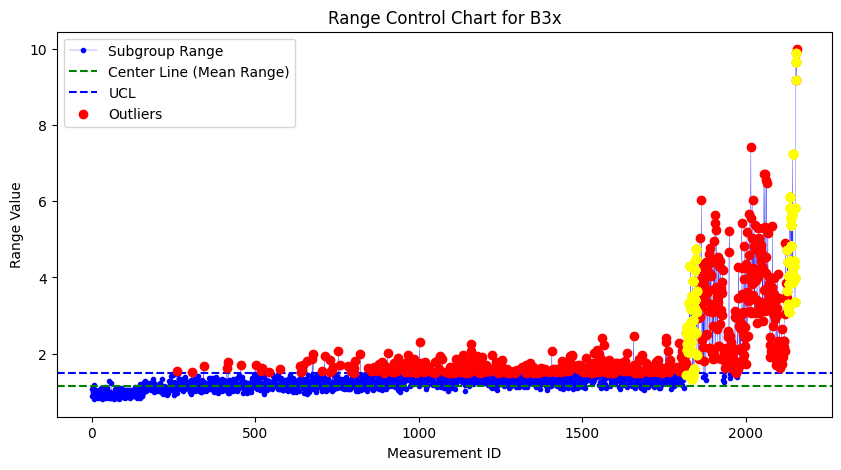

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1829, value: 1.892
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1830, value: 2.429
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1831, value: 1.929
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1832, value: 1.663
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1833, value: 2.3680000000000003
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1834, value: 1.945
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1835, value: 2.878
Alert f

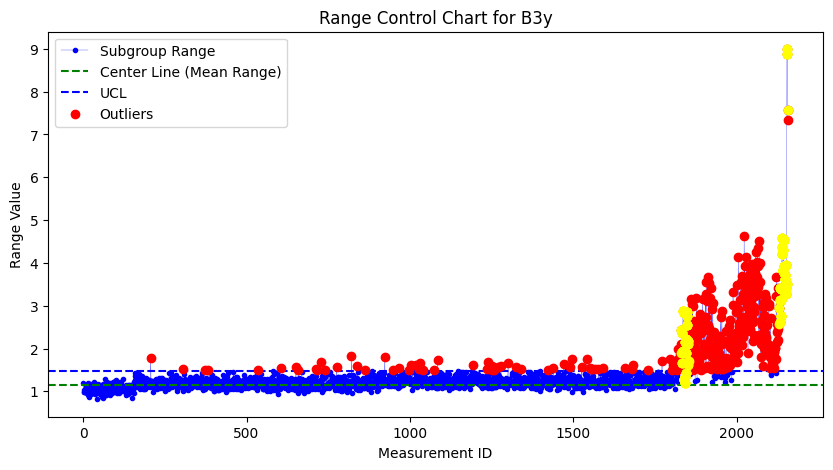

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1438, value: 1.255
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1439, value: 1.9209999999999998
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1440, value: 1.575
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1441, value: 1.458
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1442, value: 1.67
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1443, value: 1.612
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1444, value: 1.338
Alert fo

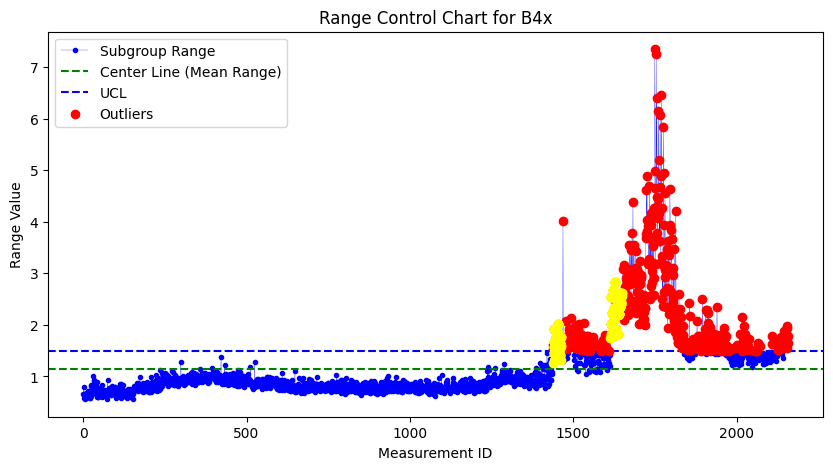

Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1435, value: 0.9279999999999999
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1436, value: 1.2890000000000001
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1437, value: 1.336
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1438, value: 1.062
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1439, value: 1.2429999999999999
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at measurement ID 1440, value: 1.2109999999999999
Alert found: anomalies detected within a rolling window of 20 and standard deviation comparison of 1.9 at me

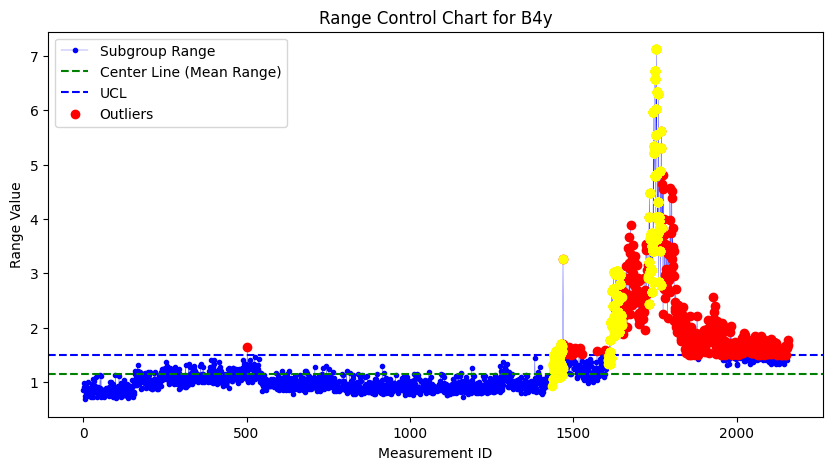

In [19]:
def plot_range_chart(data, column_name, sd=1.9, window_size=20, initial_points = 1000):
    # Calculate the range for each subgroup
    subgroup_ranges = data.groupby('measurement_id')[column_name].apply(lambda x: x.max() - x.min())
    subgroup_ranges_b1x = b1x_data.groupby('measurement_id')['B1x'].apply(lambda x: x.max() - x.min())
    
    initial_subgroup_ranges = subgroup_ranges_b1x[:initial_points]
    range_mean = initial_subgroup_ranges.mean()
    range_std = initial_subgroup_ranges.std() 

    ucl = range_mean + 3 * range_std
   

    outliers = (subgroup_ranges > ucl)

    # Detect anomalies using a rolling window
    rolling_mean = subgroup_ranges.rolling(window=window_size).mean()
    rolling_std = subgroup_ranges.rolling(window=window_size).std()
    
    anomaly_intervals = []
    for i in range(2 * window_size, len(subgroup_ranges)):
        prev_interval_mean = rolling_mean[i - 2 * window_size:i - window_size].mean()
        prev_interval_std = rolling_std[i - 2 * window_size:i - window_size].mean()
        
        curr_interval_mean = rolling_mean[i - window_size:i].mean()
        
        if curr_interval_mean > prev_interval_mean + sd * prev_interval_std:
            interval_indices = subgroup_ranges.index[i - window_size:i]
            anomaly_intervals.append(interval_indices)
            for idx in interval_indices:
                print(f"Alert found: anomalies detected within a rolling window of {window_size} and standard deviation comparison of {sd} at measurement ID {idx}, value: {subgroup_ranges[idx]}")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_ranges.index, subgroup_ranges, marker='o', linestyle='-', color='b', markersize=3, lw=0.2, label='Subgroup Range')
    plt.axhline(y=range_mean, color='green', linestyle='--', label='Center Line (Mean Range)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')
    
    # Highlighting outliers
    outliers = subgroup_ranges[(subgroup_ranges > ucl)]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)
    
    # Highlighting anomaly intervals
    for anomaly_interval in anomaly_intervals:
        plt.scatter(anomaly_interval, subgroup_ranges.loc[anomaly_interval], color='yellow', zorder=5)
    
    plt.title(f'Range Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Range Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a range control chart for each column
for column in columns:
    plot_range_chart(df, column)

## Algorithm 3: Detecting anomalies based on rolling mean
If the rolling mean increases x times an outlier is detected.

### Tip: 
You can change the parameters by placing different numbers of x (times mean increases in a row) and window_size

Alert found: rolling mean increased 13 times in a row at measurement ID 2132, value: 1.196
Alert found: rolling mean increased 13 times in a row at measurement ID 2133, value: 1.255
Alert found: rolling mean increased 13 times in a row at measurement ID 2134, value: 1.3599999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 2135, value: 1.245
Alert found: rolling mean increased 13 times in a row at measurement ID 2136, value: 1.2149999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 2137, value: 1.379
Alert found: rolling mean increased 13 times in a row at measurement ID 2138, value: 1.347
Alert found: rolling mean increased 13 times in a row at measurement ID 2139, value: 1.351
Alert found: rolling mean increased 13 times in a row at measurement ID 2140, value: 1.252
Alert found: rolling mean increased 13 times in a row at measurement ID 2141, value: 1.226
Alert found: rolling mean increased 13 times in a row at measure

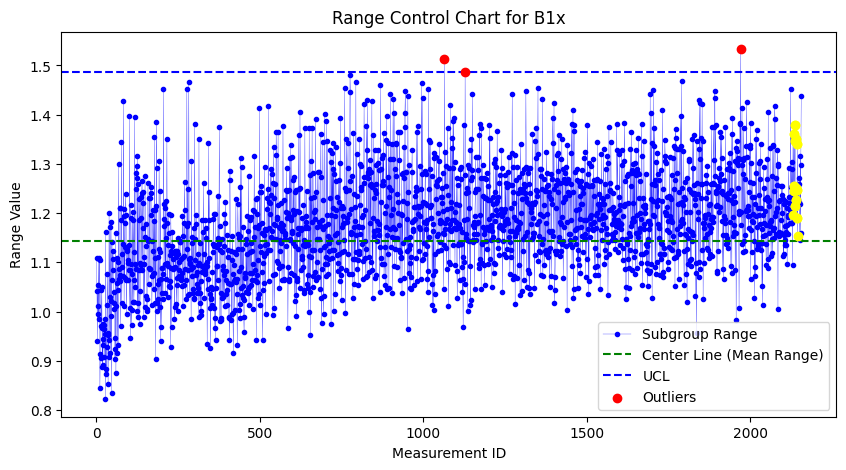

Alert found: rolling mean increased 13 times in a row at measurement ID 726, value: 1.4569999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 727, value: 1.4380000000000002
Alert found: rolling mean increased 13 times in a row at measurement ID 728, value: 1.455
Alert found: rolling mean increased 13 times in a row at measurement ID 729, value: 1.319
Alert found: rolling mean increased 13 times in a row at measurement ID 730, value: 1.482
Alert found: rolling mean increased 13 times in a row at measurement ID 731, value: 1.211
Alert found: rolling mean increased 13 times in a row at measurement ID 732, value: 1.487
Alert found: rolling mean increased 13 times in a row at measurement ID 733, value: 1.362
Alert found: rolling mean increased 13 times in a row at measurement ID 734, value: 1.318
Alert found: rolling mean increased 13 times in a row at measurement ID 735, value: 1.428
Alert found: rolling mean increased 13 times in a row at measurement ID 73

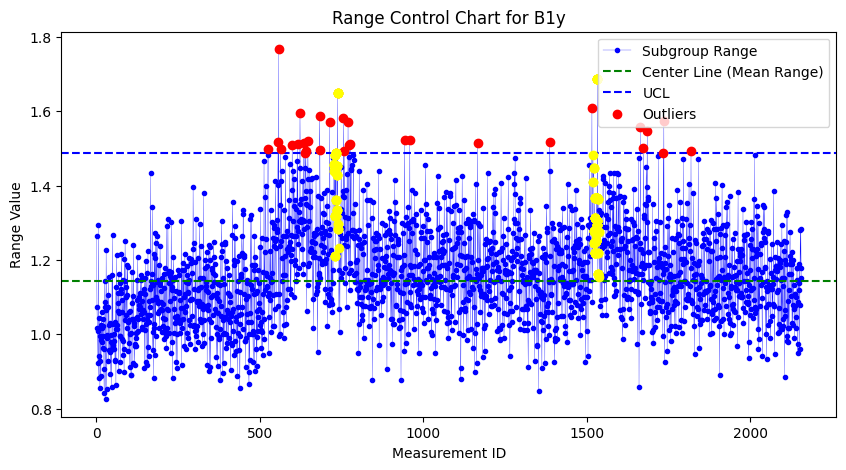

Alert found: rolling mean increased 13 times in a row at measurement ID 2131, value: 1.15
Alert found: rolling mean increased 13 times in a row at measurement ID 2132, value: 1.1720000000000002
Alert found: rolling mean increased 13 times in a row at measurement ID 2133, value: 1.097
Alert found: rolling mean increased 13 times in a row at measurement ID 2134, value: 1.221
Alert found: rolling mean increased 13 times in a row at measurement ID 2135, value: 1.164
Alert found: rolling mean increased 13 times in a row at measurement ID 2136, value: 1.179
Alert found: rolling mean increased 13 times in a row at measurement ID 2137, value: 1.103
Alert found: rolling mean increased 13 times in a row at measurement ID 2138, value: 1.194
Alert found: rolling mean increased 13 times in a row at measurement ID 2139, value: 1.186
Alert found: rolling mean increased 13 times in a row at measurement ID 2140, value: 1.203
Alert found: rolling mean increased 13 times in a row at measurement ID 2141, 

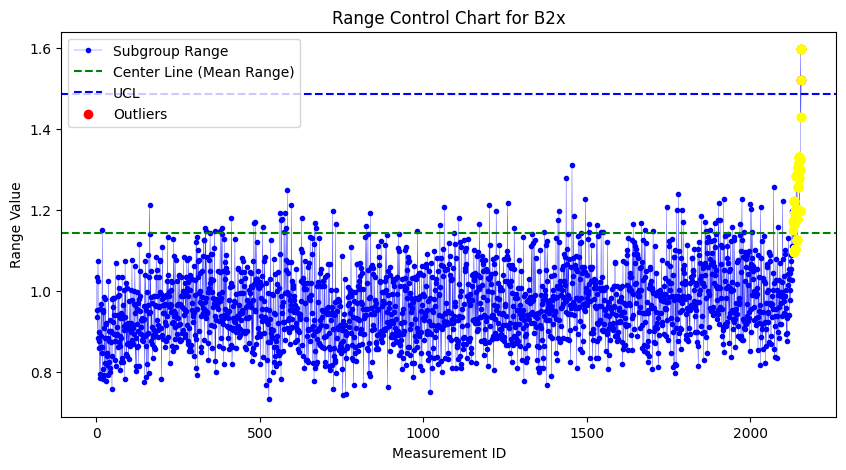

Alert found: rolling mean increased 13 times in a row at measurement ID 2129, value: 0.905
Alert found: rolling mean increased 13 times in a row at measurement ID 2130, value: 0.984
Alert found: rolling mean increased 13 times in a row at measurement ID 2131, value: 1.042
Alert found: rolling mean increased 13 times in a row at measurement ID 2132, value: 0.999
Alert found: rolling mean increased 13 times in a row at measurement ID 2133, value: 0.9329999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 2134, value: 0.972
Alert found: rolling mean increased 13 times in a row at measurement ID 2135, value: 1.109
Alert found: rolling mean increased 13 times in a row at measurement ID 2136, value: 1.069
Alert found: rolling mean increased 13 times in a row at measurement ID 2137, value: 0.971
Alert found: rolling mean increased 13 times in a row at measurement ID 2138, value: 0.989
Alert found: rolling mean increased 13 times in a row at measurement ID 2139,

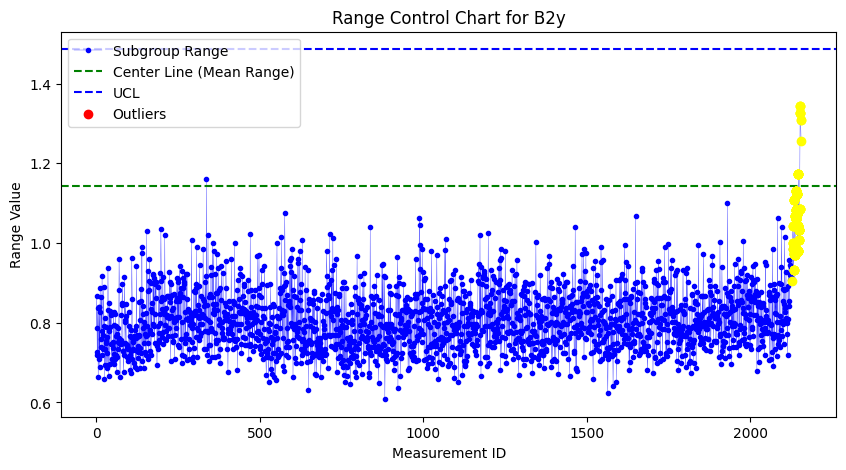

Alert found: rolling mean increased 13 times in a row at measurement ID 1813, value: 2.048
Alert found: rolling mean increased 13 times in a row at measurement ID 1814, value: 1.685
Alert found: rolling mean increased 13 times in a row at measurement ID 1815, value: 1.927
Alert found: rolling mean increased 13 times in a row at measurement ID 1816, value: 1.7429999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 1817, value: 1.724
Alert found: rolling mean increased 13 times in a row at measurement ID 1818, value: 2.551
Alert found: rolling mean increased 13 times in a row at measurement ID 1819, value: 1.4260000000000002
Alert found: rolling mean increased 13 times in a row at measurement ID 1820, value: 2.246
Alert found: rolling mean increased 13 times in a row at measurement ID 1821, value: 2.702
Alert found: rolling mean increased 13 times in a row at measurement ID 1822, value: 2.085
Alert found: rolling mean increased 13 times in a row at measure

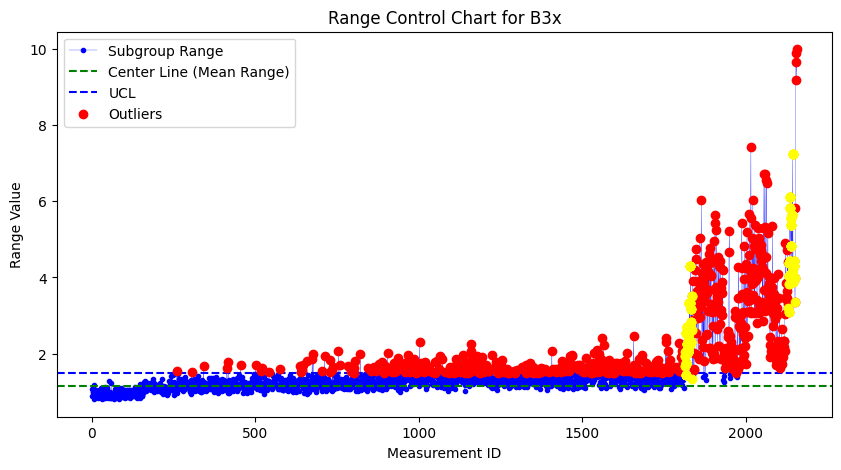

Alert found: rolling mean increased 13 times in a row at measurement ID 2130, value: 2.9539999999999997
Alert found: rolling mean increased 13 times in a row at measurement ID 2131, value: 2.6100000000000003
Alert found: rolling mean increased 13 times in a row at measurement ID 2132, value: 3.128
Alert found: rolling mean increased 13 times in a row at measurement ID 2133, value: 3.418
Alert found: rolling mean increased 13 times in a row at measurement ID 2134, value: 2.759
Alert found: rolling mean increased 13 times in a row at measurement ID 2135, value: 3.14
Alert found: rolling mean increased 13 times in a row at measurement ID 2136, value: 3.394
Alert found: rolling mean increased 13 times in a row at measurement ID 2137, value: 4.2090000000000005
Alert found: rolling mean increased 13 times in a row at measurement ID 2138, value: 4.383
Alert found: rolling mean increased 13 times in a row at measurement ID 2139, value: 4.593
Alert found: rolling mean increased 13 times in a ro

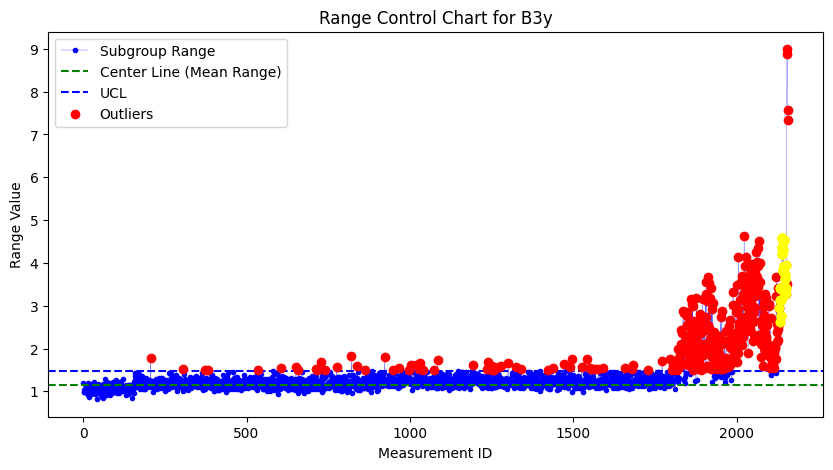

Alert found: rolling mean increased 13 times in a row at measurement ID 155, value: 0.8170000000000001
Alert found: rolling mean increased 13 times in a row at measurement ID 156, value: 0.784
Alert found: rolling mean increased 13 times in a row at measurement ID 157, value: 0.7979999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 158, value: 0.786
Alert found: rolling mean increased 13 times in a row at measurement ID 159, value: 0.747
Alert found: rolling mean increased 13 times in a row at measurement ID 160, value: 0.749
Alert found: rolling mean increased 13 times in a row at measurement ID 161, value: 0.732
Alert found: rolling mean increased 13 times in a row at measurement ID 162, value: 0.764
Alert found: rolling mean increased 13 times in a row at measurement ID 163, value: 0.788
Alert found: rolling mean increased 13 times in a row at measurement ID 164, value: 0.8029999999999999
Alert found: rolling mean increased 13 times in a row at meas

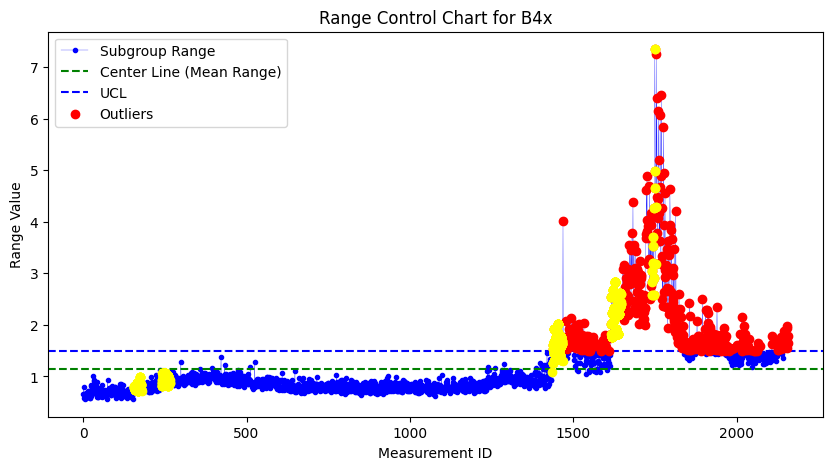

Alert found: rolling mean increased 13 times in a row at measurement ID 158, value: 1.194
Alert found: rolling mean increased 13 times in a row at measurement ID 159, value: 1.04
Alert found: rolling mean increased 13 times in a row at measurement ID 160, value: 1.1469999999999998
Alert found: rolling mean increased 13 times in a row at measurement ID 161, value: 0.94
Alert found: rolling mean increased 13 times in a row at measurement ID 162, value: 1.023
Alert found: rolling mean increased 13 times in a row at measurement ID 163, value: 1.091
Alert found: rolling mean increased 13 times in a row at measurement ID 164, value: 0.9349999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 165, value: 1.1059999999999999
Alert found: rolling mean increased 13 times in a row at measurement ID 166, value: 1.1640000000000001
Alert found: rolling mean increased 13 times in a row at measurement ID 167, value: 1.3090000000000002
Alert found: rolling mean increased 1

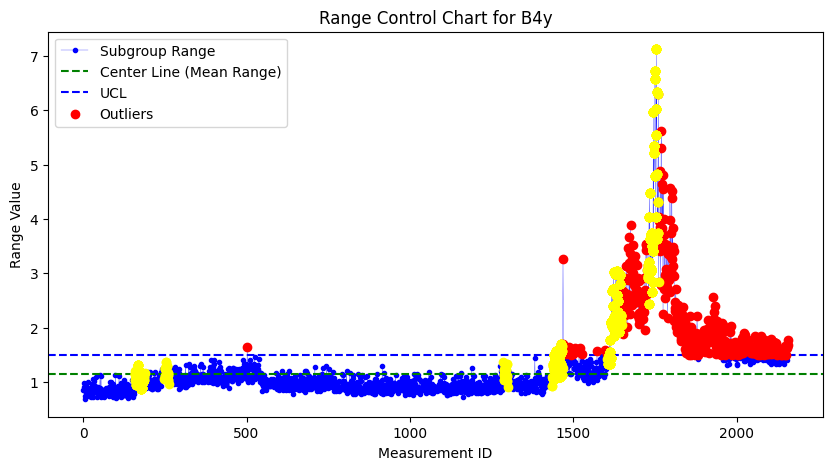

In [22]:
def plot_range_chart_with_consecutive_increases(data, column_name, x=13, window_size=30, initial_points = 1000):
    # Calculate the range for each subgroup
    subgroup_ranges = data.groupby('measurement_id')[column_name].apply(lambda x: x.max() - x.min())
    subgroup_ranges_b1x = b1x_data.groupby('measurement_id')['B1x'].apply(lambda x: x.max() - x.min())
    
    initial_subgroup_ranges = subgroup_ranges_b1x[:initial_points]
    range_mean = initial_subgroup_ranges.mean()
    range_std = initial_subgroup_ranges.std() 
    
    ucl = range_mean + 3 * range_std
    
    # Define control limits


    # Calculate rolling mean
    rolling_mean = subgroup_ranges.rolling(window=window_size).mean()
    
    consecutive_increases = 0
    anomaly_intervals = []
    
    for i in range(window_size, len(subgroup_ranges)):
        if rolling_mean[i] > rolling_mean[i - 1]:
            consecutive_increases += 1
        else:
            consecutive_increases = 0
        
        if consecutive_increases >= x:
            interval_indices = subgroup_ranges.index[i - x + 1:i + 1]
            anomaly_intervals.append(interval_indices)
            for idx in interval_indices:
                print(f"Alert found: rolling mean increased {x} times in a row at measurement ID {idx}, value: {subgroup_ranges[idx]}")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(subgroup_ranges.index, subgroup_ranges, marker='o', linestyle='-', color='b', markersize=3, lw=0.2, label='Subgroup Range')
    plt.axhline(y=range_mean, color='green', linestyle='--', label='Center Line (Mean Range)')
    plt.axhline(y=ucl, color='blue', linestyle='--', label='UCL')
    
    # Highlighting outliers
    outliers = subgroup_ranges[(subgroup_ranges > ucl)]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)
    
    # Highlighting anomaly intervals
    for anomaly_interval in anomaly_intervals:
        plt.scatter(anomaly_interval, subgroup_ranges.loc[anomaly_interval], color='yellow', zorder=5)
    
    plt.title(f'Range Control Chart for {column_name}')
    plt.xlabel('Measurement ID')
    plt.ylabel('Range Value')
    plt.legend()
    plt.show()

# Column names for each bearing axis
columns = ['B1x', 'B1y', 'B2x', 'B2y', 'B3x', 'B3y', 'B4x', 'B4y']

# Generate a range control chart for each column
for column in columns:
    plot_range_chart_with_consecutive_increases(df, column)

## Conclusion
In this project, we developed and applied control charts to detect anomalies in vibration data from various bearings. By analyzing range and mean values, we established control limits and successfully identified outliers.